在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数、使用Nadam优化和早停技术
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

# 一、加载数据集(图片数据需归一化)

In [1]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


<span style="color:red">注意：下面单元格的代码只能运行一次，否则会过分缩放数据导致训练效果不好</span>

In [2]:
X_train_full, X_test = X_train_full / 255., X_test / 255.

In [3]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

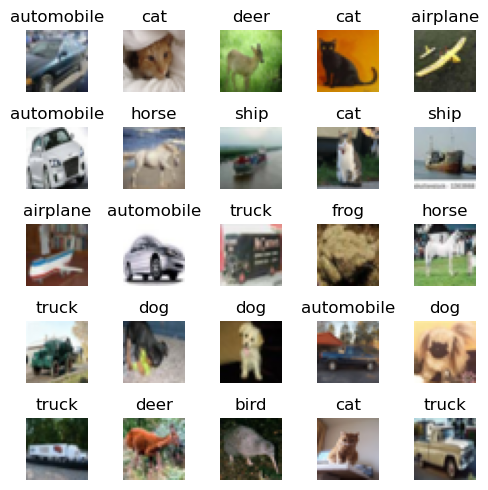

In [4]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

# 二、构建神经网络

In [5]:
import tensorflow as tf

def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

def swish(x, beta=1):
    return x * sigmoid(beta * x)

# 模型创建
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, activation=swish, kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))


# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

class get_lr(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lr_list = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.lr_list.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(logs["loss"])

learning_rate_callback = get_lr()

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)
history = model.fit(X_train_full, y_train_full, epochs=100, validation_data=(X_test, y_test),
          callbacks=[early_stop, learning_rate_callback])

Epoch 1/100
1563/1563 [==============================] - 21s 10ms/step - loss: 1.9163 - accuracy: 0.2885 - val_loss: 1.7988 - val_accuracy: 0.3441
Epoch 2/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.7162 - accuracy: 0.3765 - val_loss: 1.6638 - val_accuracy: 0.4042
Epoch 3/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.6152 - accuracy: 0.4156 - val_loss: 1.5616 - val_accuracy: 0.4434
Epoch 4/100
1563/1563 [==============================] - 16s 10ms/step - loss: 1.5567 - accuracy: 0.4388 - val_loss: 1.5327 - val_accuracy: 0.4533
Epoch 5/100
1563/1563 [==============================] - 17s 11ms/step - loss: 1.5136 - accuracy: 0.4544 - val_loss: 1.5240 - val_accuracy: 0.4554
Epoch 6/100
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4761 - accuracy: 0.4701 - val_loss: 1.4905 - val_accuracy: 0.4661
Epoch 7/100
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4424 - accuracy: 0.4818 - val_loss: 1

In [6]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4737 - accuracy: 0.5040


[1.4737170934677124, 0.5040000081062317]

## 添加批量归一化

In [7]:
model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model1.add(tf.keras.layers.Dense(100, activation=swish, kernel_initializer="he_normal"))
    model1.add(tf.keras.layers.BatchNormalization())
model1.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=3e-4)

model1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

class get_lr(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.lr_list = []
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        self.lr_list.append(self.model.optimizer.learning_rate.numpy())
        self.losses.append(logs["loss"])

learning_rate_callback1 = get_lr()

history = model1.fit(X_train_full, y_train_full, epochs=10, validation_data=(X_test, y_test),
          callbacks=[early_stop, learning_rate_callback1])

Epoch 1/10
1563/1563 [==============================] - 40s 18ms/step - loss: 2.3577 - accuracy: 0.1536 - val_loss: 2.1269 - val_accuracy: 0.2284
Epoch 2/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.9961 - accuracy: 0.2635 - val_loss: 1.8967 - val_accuracy: 0.3061
Epoch 3/10
1563/1563 [==============================] - 26s 17ms/step - loss: 1.8731 - accuracy: 0.3186 - val_loss: 1.8337 - val_accuracy: 0.3421
Epoch 4/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.7971 - accuracy: 0.3507 - val_loss: 1.7916 - val_accuracy: 0.3681
Epoch 5/10
1563/1563 [==============================] - 28s 18ms/step - loss: 1.7398 - accuracy: 0.3775 - val_loss: 1.7180 - val_accuracy: 0.3797
Epoch 6/10
1563/1563 [==============================] - 29s 18ms/step - loss: 1.6877 - accuracy: 0.3971 - val_loss: 1.6576 - val_accuracy: 0.4053
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 1.6432 - accuracy: 0.4145 - val_loss: 1.7173 -

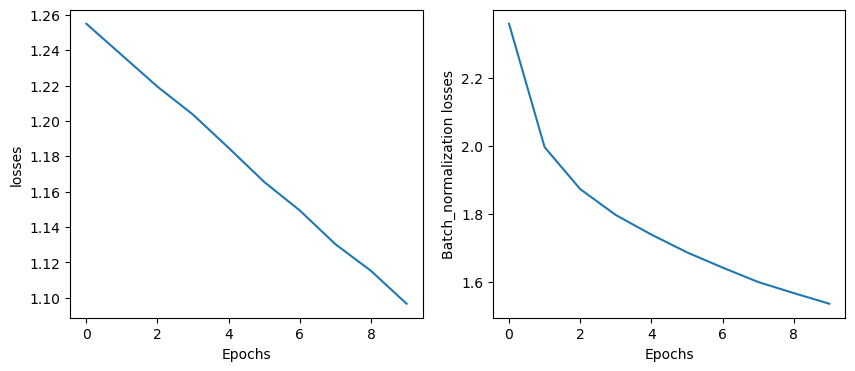

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(range(10), learning_rate_callback.losses[-10:])
plt.xlabel("Epochs")
plt.ylabel("losses")

plt.subplot(122)
plt.plot(range(10), learning_rate_callback1.losses)
plt.xlabel("Epochs")
plt.ylabel("Batch_normalization losses")
plt.show()

## SELU替换批量归一化

In [11]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model2.add(tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

history = model2.fit(X_train_full, y_train_full, epochs=10, validation_data=(X_test, y_test),
          callbacks=[early_stop, learning_rate_callback])

Epoch 1/10
1563/1563 [==============================] - 24s 12ms/step - loss: 1.8461 - accuracy: 0.3314 - val_loss: 1.7027 - val_accuracy: 0.3795
Epoch 2/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.6828 - accuracy: 0.3908 - val_loss: 1.6204 - val_accuracy: 0.4119
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.6099 - accuracy: 0.4219 - val_loss: 1.5790 - val_accuracy: 0.4343
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.5570 - accuracy: 0.4416 - val_loss: 1.5730 - val_accuracy: 0.4375
Epoch 5/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.5184 - accuracy: 0.4555 - val_loss: 1.5213 - val_accuracy: 0.4539
Epoch 6/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.4847 - accuracy: 0.4668 - val_loss: 1.5187 - val_accuracy: 0.4588
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.4556 - accuracy: 0.4769 - val_loss: 1.4797 -

In [12]:
model2.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.4337 - accuracy: 0.4914


[1.4336954355239868, 0.49140000343322754]

### 使用Alpha dropout正则化模型

In [13]:
model3 = tf.keras.Sequential()

model3.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model3.add(tf.keras.layers.Dense(100,
                                     activation="selu",
                                     kernel_initializer="lecun_normal"))
    model3.add(tf.keras.layers.AlphaDropout(rate=0.02))
model3.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=9e-5)

model3.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

history = model3.fit(X_train_full, y_train_full,
                     epochs=10,
                     validation_data=(X_test, y_test),
                     callbacks=[early_stop])

Epoch 1/10
1563/1563 [==============================] - 30s 15ms/step - loss: 2.2094 - accuracy: 0.1945 - val_loss: 1.9019 - val_accuracy: 0.2912
Epoch 2/10
1563/1563 [==============================] - 25s 16ms/step - loss: 1.9638 - accuracy: 0.2712 - val_loss: 1.8388 - val_accuracy: 0.3315
Epoch 3/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.8723 - accuracy: 0.3113 - val_loss: 1.8039 - val_accuracy: 0.3565
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.8097 - accuracy: 0.3415 - val_loss: 1.7482 - val_accuracy: 0.3718
Epoch 5/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.7690 - accuracy: 0.3580 - val_loss: 1.6654 - val_accuracy: 0.4036
Epoch 6/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1.7340 - accuracy: 0.3725 - val_loss: 1.6472 - val_accuracy: 0.4151
Epoch 7/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.7034 - accuracy: 0.3876 - val_loss: 1.6363 -

In [14]:
model3.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.5724 - accuracy: 0.4396


[1.5723931789398193, 0.43959999084472656]

## 一周期调度
其原理为：在训练的大约一半时间内线性增加学习率，然后线性降低回初始学习率，最后在训练的最后阶段将学习率线性/指数降低到0

In [15]:
import math
model4 = tf.keras.Sequential()

model4.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model4.add(tf.keras.layers.Dense(100,
                                     activation=swish,
                                     kernel_initializer="he_normal"))
model4.add(tf.keras.layers.Dense(10, activation="softmax"))

# 模型编译
optimizers = tf.keras.optimizers.Nadam(learning_rate=1e-5)

model4.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers,
    metrics=["accuracy"]
)

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr, start_lr=None,
                 last_iterations=None, last_lr=None):
        super().__init__()
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

batch_size = 128
n_epochs = 10
m = X_train_full.shape[0]
one_cycle_sc = OneCycleScheduler(math.ceil(m / batch_size) * n_epochs, max_lr=0.001)

# 模型训练
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)

history = model4.fit(X_train_full, y_train_full, epochs=n_epochs, batch_size=batch_size, validation_data=(X_test, y_test),
          callbacks=[early_stop, one_cycle_sc])

Epoch 1/10
391/391 [==============================] - 13s 18ms/step - loss: 1.9888 - accuracy: 0.2575 - val_loss: 1.8407 - val_accuracy: 0.3258
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 1.7640 - accuracy: 0.3588 - val_loss: 1.7303 - val_accuracy: 0.3814
Epoch 3/10
391/391 [==============================] - 7s 17ms/step - loss: 1.6723 - accuracy: 0.3978 - val_loss: 1.6690 - val_accuracy: 0.3971
Epoch 4/10
391/391 [==============================] - 7s 18ms/step - loss: 1.6137 - accuracy: 0.4226 - val_loss: 1.6787 - val_accuracy: 0.3952
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 1.5658 - accuracy: 0.4402 - val_loss: 1.5678 - val_accuracy: 0.4369
Epoch 6/10
391/391 [==============================] - 7s 18ms/step - loss: 1.4884 - accuracy: 0.4687 - val_loss: 1.4580 - val_accuracy: 0.4867
Epoch 7/10
391/391 [==============================] - 7s 18ms/step - loss: 1.4181 - accuracy: 0.4918 - val_loss: 1.4639 - val_accuracy: 0.476

In [16]:
model4.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.3821 - accuracy: 0.5170


[1.3820663690567017, 0.5170000195503235]